In [2]:
from fastai.vision.all import *
import fastai
import timm
import torch
import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [3]:
torch.cuda.set_device(0)

In [4]:
df = pd.read_csv('../trainValid.csv')

In [5]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [6]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [7]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='twins_svt_base_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [10]:
learn = Learner(dls,timm.create_model('visformer_small',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [11]:
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.182507,0.171733,0.550000,0.530046,0.882051,0.662175,0.628764,01:57


Better model found at epoch 0 with f1_score value: 0.6621751684311838.


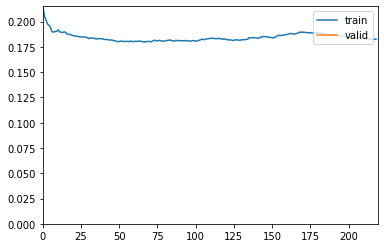

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.177891,0.173468,0.498718,0.499343,0.974359,0.660295,0.619734,02:01
1,0.176802,0.172401,0.506410,0.503458,0.933333,0.654088,0.599855,02:01
2,0.175948,0.171634,0.551282,0.529412,0.923077,0.672897,0.632156,02:01
3,0.177923,0.171855,0.558974,0.536050,0.876923,0.665370,0.628488,02:01
4,0.175893,0.170373,0.611538,0.638095,0.515385,0.570213,0.636838,02:01
5,0.175095,0.169759,0.592308,0.564982,0.802564,0.663136,0.640773,02:01
6,0.173420,0.169280,0.630769,0.619718,0.676923,0.647059,0.652064,02:00
7,0.172279,0.168255,0.610256,0.588477,0.733333,0.652968,0.656210,02:01
8,0.173959,0.168523,0.617949,0.598712,0.715385,0.651869,0.659977,02:00
9,0.172254,0.164294,0.634615,0.698113,0.474359,0.564885,0.697659,02:01


Better model found at epoch 0 with f1_score value: 0.6602953953084275.


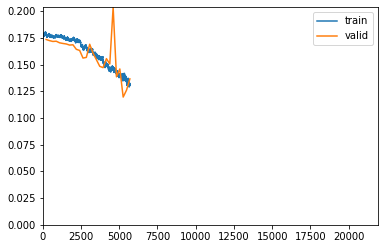

Better model found at epoch 2 with f1_score value: 0.6728971962616822.
Better model found at epoch 11 with f1_score value: 0.6981566820276498.
Better model found at epoch 18 with f1_score value: 0.7214377406931964.
Better model found at epoch 22 with f1_score value: 0.7214484679665739.
Better model found at epoch 23 with f1_score value: 0.7808219178082191.


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

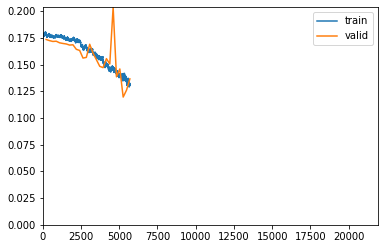

In [12]:
learn.fine_tune(100,base_lr=2e-4)

In [13]:
learn.load('twins_svt_base_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [14]:
dfTest = pd.read_csv('../testSample.csv')

In [15]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [17]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=32,num_workers=0)

In [18]:
learn.dls = dlsTest

In [19]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.8908828402366864.


(#6) [0.11693978309631348,0.8041025400161743,0.8205405405405405,0.7784615384615384,0.7989473684210526,0.8908828402366864]